In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# read the data and remove outliers

In [51]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_05_07.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_20_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_25_06.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

In [52]:
# Remove outliers in 'price_per_night' using the IQR method
Q1 = df['price_per_night'].quantile(0.25)
Q3 = df['price_per_night'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where 'price_per_night' is an outlier
df = df[(df['price_per_night'] >= lower_bound) & (df['price_per_night'] <= upper_bound)]

In [53]:
df["full_price"] = df["price_per_night"] * df["LOS"]

# Run radom forest model to predict price per night: 

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest Regressor Results:
Train R2: 0.6938133216539633
Train RMSE: 27.80695167385293
Train MSE: 773.2265613919922
Train MAE: 20.72124551182297
Test R2: 0.6030268917968051
Test RMSE: 31.989285707051334
Test MSE: 1023.3144000473587
Test MAE: 23.772294416614866
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}


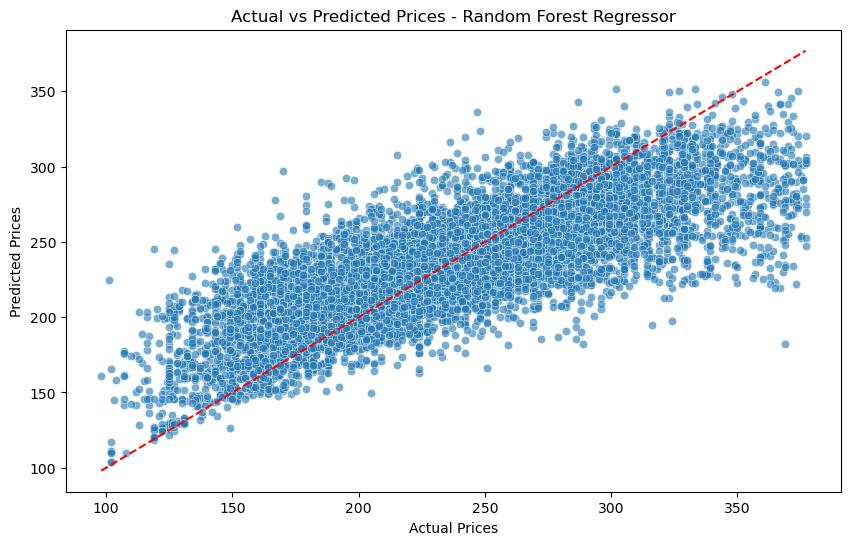

In [50]:
# Remove columns that are not needed for regression
columns_to_use = ['TTT', 'LOS', 'score',
       'reviews', 'price_per_night',
       'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
       'star_rating', 'location_rating',
       'km_from_center']
df = df[columns_to_use]


# Keep only numeric columns
df = df.select_dtypes(include=[np.number])

# Remove columns with all NaN values
df = df.dropna(axis=1, how='all')

# Ensure there are no remaining NaN values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Split the data into train and test sets
X = df.drop(columns=['price_per_night'])
y = df['price_per_night']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [ 8, 10,12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'n_estimators': [50,75 ,100]
}

# Initialize Random Forest Regressor with GridSearchCV
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print results
print("Random Forest Regressor Results:")
print(f"Train R2: {train_r2}")
print(f"Train RMSE: {train_rmse}")
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test R2: {test_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Best Parameters: {grid_search.best_params_}")

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Random Forest Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

# Feature Engineering process on the data:

In [54]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# df = pd.concat([df1, df2, df3], ignore_index=True)

# Ensure 'Snapshot' is in datetime format
df['Snapshot'] = pd.to_datetime(df['Snapshot'], errors='coerce')

# Ensure 'TTT' and 'LOS' are numeric
df['TTT'] = pd.to_numeric(df['TTT'], errors='coerce')
df['LOS'] = pd.to_numeric(df['LOS'], errors='coerce')

# Calculate check-in date by adding 'TTT' to 'Snapshot'
df['checkin'] = df['Snapshot'] + pd.to_timedelta(df['TTT'], unit='d')

# Calculate check-out date by adding 'LOS' to 'checkin'
df['checkout'] = df['checkin'] + pd.to_timedelta(df['LOS'], unit='d')

# Add columns for the day name of check-in and check-out
df['checkin_day_name'] = df['checkin'].dt.day_name()
df['checkout_day_name'] = df['checkout'].dt.day_name()

# Convert day names to categorical variables
df['checkin_day_name'] = df['checkin_day_name'].astype('category')
df['checkout_day_name'] = df['checkout_day_name'].astype('category')


# Calculate check-in date by adding 'TTT' to 'Snapshot'
df['checkin'] = df['Snapshot'] + pd.to_timedelta(df['TTT'], unit='d')

# Calculate check-out date by adding 'LOS' to 'checkin'
df['checkout'] = df['checkin'] + pd.to_timedelta(df['LOS'], unit='d')

# Add columns for the day of the month for check-in and check-out
df['checkin_day'] = df['checkin'].dt.day
df['checkout_day'] = df['checkout'].dt.day

# Function to determine the period of the month
def determine_period(start_day, end_day):
    avg_day = (start_day + end_day) / 2
    if avg_day < 10:
        return 'beginning of the month'
    elif 10 <= avg_day < 22:
        return 'middle of the month'
    else:
        return 'end of the month'

# Apply the function to create the 'period_of_the_month' column
df['period_of_the_month'] = df.apply(lambda row: determine_period(row['checkin_day'], row['checkout_day']), axis=1)

# Perform one-hot encoding for 'checkin_day_name', 'checkout_day_name', and 'period_of_the_month'
checkin_encoder = OneHotEncoder(sparse=False)
encoded_checkin = checkin_encoder.fit_transform(df[['checkin_day_name']])

checkout_encoder = OneHotEncoder(sparse=False)
encoded_checkout = checkout_encoder.fit_transform(df[['checkout_day_name']])

period_encoder = OneHotEncoder(sparse=False)
encoded_period = period_encoder.fit_transform(df[['period_of_the_month']])

# Create DataFrames for the encoded columns
encoded_checkin_df = pd.DataFrame(encoded_checkin, columns=checkin_encoder.get_feature_names_out(['checkin_day_name']))
encoded_checkout_df = pd.DataFrame(encoded_checkout, columns=checkout_encoder.get_feature_names_out(['checkout_day_name']))
encoded_period_df = pd.DataFrame(encoded_period, columns=period_encoder.get_feature_names_out(['period_of_the_month']))

# Drop the original columns and concatenate the new one-hot encoded columns
df = df.drop(columns=['checkin_day_name', 'checkout_day_name', 'period_of_the_month'])
df = df.join(encoded_checkin_df).join(encoded_checkout_df).join(encoded_period_df)

# Save the updated DataFrame to a new CSV file
# output_file = './05_07_hotels_data_cleaned_with_days_name_parameters_period_encoded.csv'
# df.to_csv(output_file, index=False)

# Display the first few rows of the updated DataFrame
print(df.head())

C:\Users\User\AppData\Local\Temp\ipykernel_12324\1617303282.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Snapshot'] = pd.to_datetime(df['Snapshot'], errors='coerce')


             Snapshot  start_date    end_date  \
0 2024-07-12 14:43:06  06/07/2024  07/07/2024   
1 2024-07-12 14:43:06  06/07/2024  07/07/2024   
2 2024-07-12 14:43:12  06/07/2024  07/07/2024   
3 2024-07-12 14:43:12  06/07/2024  07/07/2024   
4 2024-07-12 14:43:12  06/07/2024  07/07/2024   

                                                name  TTT  LOS  score  \
0                               Omni Berkshire Place    1    1   9.29   
1                         The Washington by LuxUrban    1    1   8.28   
2                       Hyatt Grand Central New York    1    1   8.08   
3  The Cloud One New York-Downtown, by the Motel ...    1    1   8.88   
4                              45 Times Square Hotel    1    1   8.68   

   reviews  price_per_night  original_price  ...  checkout_day_name_Monday  \
0     1223              269             299  ...                       0.0   
1     1006              188             209  ...                       0.0   
2     3726              246     

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Run random forest model on data with the new features

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest Regressor Results:
Train R2: 0.7533793579069434
Train RMSE: 24.95599836429883
Train MSE: 622.8018543588857
Train MAE: 18.77404358204365
Test R2: 0.6748935368453606
Test RMSE: 28.949215594120773
Test MSE: 838.0570835148853
Test MAE: 21.740949593456403
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


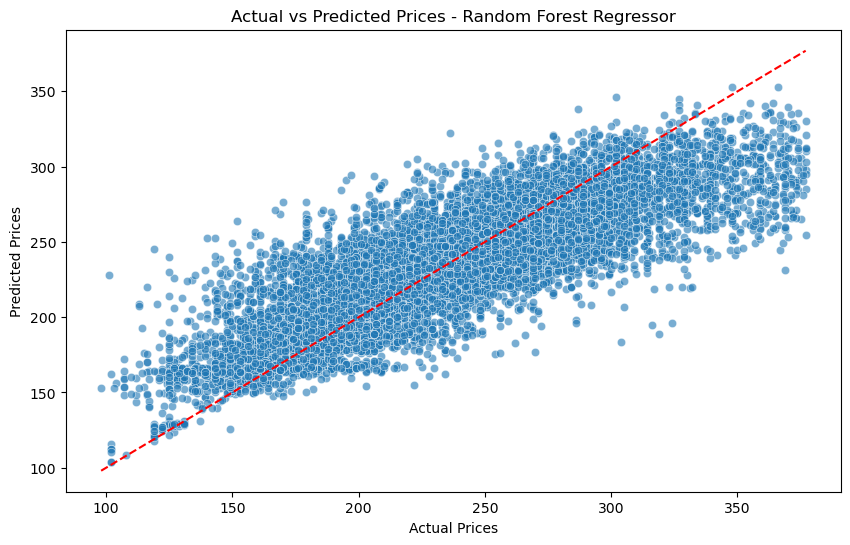

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)

# Remove columns that are not needed for regression
columns_to_use = ['TTT', 'LOS', 'score',
       'reviews', 'price_per_night',
       'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
       'star_rating', 'location_rating',
       'km_from_center',
       'checkin_day', 'checkout_day', 'checkin_day_name_Friday',
       'checkin_day_name_Monday', 'checkin_day_name_Saturday',
       'checkin_day_name_Sunday', 'checkin_day_name_Thursday',
       'checkin_day_name_Tuesday', 'checkin_day_name_Wednesday',
       'checkin_day_name_nan', 'checkout_day_name_Friday',
       'checkout_day_name_Monday', 'checkout_day_name_Saturday',
       'checkout_day_name_Sunday', 'checkout_day_name_Thursday',
       'checkout_day_name_Tuesday', 'checkout_day_name_Wednesday',
       'checkout_day_name_nan', 'period_of_the_month_beginning of the month',
       'period_of_the_month_end of the month',
       'period_of_the_month_middle of the month']
df = df[columns_to_use]

# Keep only numeric columns
df = df.select_dtypes(include=[np.number])

# Remove columns with all NaN values
df = df.dropna(axis=1, how='all')

# Ensure there are no remaining NaN values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Split the data into train and test sets
X = df.drop(columns=['price_per_night'])
y = df['price_per_night']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [8, 10,12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'n_estimators': [50, 75 ,100]
}

# Initialize Random Forest Regressor with GridSearchCV
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print results
print("Random Forest Regressor Results:")
print(f"Train R2: {train_r2}")
print(f"Train RMSE: {train_rmse}")
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test R2: {test_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Best Parameters: {grid_search.best_params_}")

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Random Forest Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

# Run the model to predict the full price

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest Regressor Results:
Train R2: 0.9367395541175699
Train RMSE: 92.28347673712533
Train MSE: 8516.240078691551
Train MAE: 64.61055394348213
Test R2: 0.917261184188666
Test RMSE: 106.41855070650671
Test MSE: 11324.907934473338
Test MAE: 74.72300044487481
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


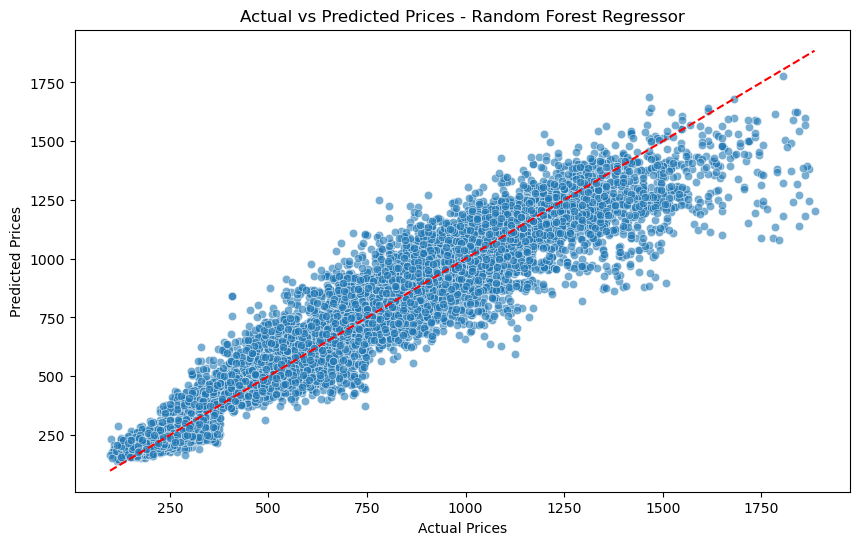

In [38]:
columns_to_use = ['TTT', 'LOS', 'score',
       'reviews', 'full_price',
       'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
       'star_rating', 'location_rating',
       'km_from_center']
df = df[columns_to_use]

# Keep only numeric columns
df = df.select_dtypes(include=[np.number])

# Remove columns with all NaN values
df = df.dropna(axis=1, how='all')

# Ensure there are no remaining NaN values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Split the data into train and test sets
X = df.drop(columns=['full_price'])
y = df['full_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [ 8, 10,12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'n_estimators': [50,75 ,100]
}

# Initialize Random Forest Regressor with GridSearchCV
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print results
print("Random Forest Regressor Results:")
print(f"Train R2: {train_r2}")
print(f"Train RMSE: {train_rmse}")
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test R2: {test_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Best Parameters: {grid_search.best_params_}")

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Random Forest Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

# Run the model to predict full price using new features (features engineering)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest Regressor Results:
Train R2: 0.9503836466698963
Train RMSE: 81.72788205207199
Train MSE: 6679.446704717392
Train MAE: 58.287551182356616
Test R2: 0.9347626691034614
Test RMSE: 94.49542479846966
Test MSE: 8929.385307843233
Test MAE: 68.08282381729347
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


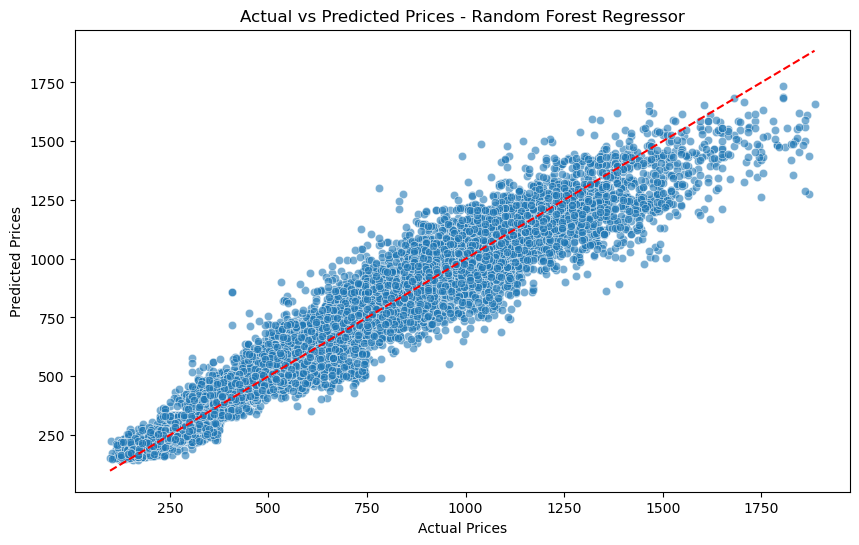

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)

# Remove columns that are not needed for regression
columns_to_use = ['TTT', 'LOS', 'score',
       'reviews', 'full_price',
       'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
       'star_rating', 'location_rating',
       'km_from_center', 'checkin_day', 'checkout_day', 'checkin_day_name_Friday',
       'checkin_day_name_Monday', 'checkin_day_name_Saturday',
       'checkin_day_name_Sunday', 'checkin_day_name_Thursday',
       'checkin_day_name_Tuesday', 'checkin_day_name_Wednesday',
       'checkin_day_name_nan', 'checkout_day_name_Friday',
       'checkout_day_name_Monday', 'checkout_day_name_Saturday',
       'checkout_day_name_Sunday', 'checkout_day_name_Thursday',
       'checkout_day_name_Tuesday', 'checkout_day_name_Wednesday',
       'checkout_day_name_nan', 'period_of_the_month_beginning of the month',
       'period_of_the_month_end of the month',
       'period_of_the_month_middle of the month']
df = df[columns_to_use]

# Keep only numeric columns
df = df.select_dtypes(include=[np.number])

# Remove columns with all NaN values
df = df.dropna(axis=1, how='all')

# Ensure there are no remaining NaN values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Split the data into train and test sets
X = df.drop(columns=['full_price'])
y = df['full_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [8, 10,12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'n_estimators': [50, 75 ,100]
}

# Initialize Random Forest Regressor with GridSearchCV
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print results
print("Random Forest Regressor Results:")
print(f"Train R2: {train_r2}")
print(f"Train RMSE: {train_rmse}")
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test R2: {test_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Best Parameters: {grid_search.best_params_}")

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Random Forest Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()